In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/dataset_all.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [4]:
import os
import shutil

# 原始路徑
base_input_path = '/content/data/dataset_all'  # 改成你解壓縮後的根目錄
base_output_path = '/content/image_classification_data'

splits = ['train', 'val', 'test']

for split in splits:
    image_dir = os.path.join(base_input_path, split, 'images')
    label_dir = os.path.join(base_input_path, split, 'labels')
    output_split_dir = os.path.join(base_output_path, split)

    os.makedirs(output_split_dir, exist_ok=True)

    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if not lines:
                continue
            class_id = lines[0].split()[0]  # YOLO 格式的第一個欄位是類別

        image_name = label_file.replace('.txt', '.jpg')  # 或 .png，根據你的檔名決定
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            continue

        class_dir = os.path.join(output_split_dir, class_id)
        os.makedirs(class_dir, exist_ok=True)

        shutil.copy(image_path, os.path.join(class_dir, image_name))


In [5]:
import os
import pandas as pd

def create_multilabel_csv(image_dir, label_dir, output_csv):
    data = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                continue
            # 擷取每一行的 class_id，放進集合避免重複
            classes = set()
            for line in lines:
                class_id = line.split()[0]
                classes.add(class_id)
        image_name = label_file.replace('.txt', '.jpg')  # 或改成你用的副檔名
        data.append({'image_name': image_name, 'labels': ' '.join(sorted(classes))})

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Saved multilabel CSV to {output_csv}")

# 範例路徑，改成你實際路徑
train_img_dir = '/content/data/dataset_all/train/images'
train_label_dir = '/content/data/dataset_all/train/labels'
val_img_dir = '/content/data/dataset_all/val/images'
val_label_dir = '/content/data/dataset_all/val/labels'

# 產生CSV
create_multilabel_csv(train_img_dir, train_label_dir, '/content/image_classification_data/train_labels.csv')
create_multilabel_csv(val_img_dir, val_label_dir, '/content/image_classification_data/val_labels.csv')


Saved multilabel CSV to /content/image_classification_data/train_labels.csv
Saved multilabel CSV to /content/image_classification_data/val_labels.csv


In [7]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

# 1. 自訂 Dataset
class MultiLabelDataset(Dataset):
    def __init__(self, csv_path, img_dir, num_classes, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = row['labels'].split()  # 假設 labels 是以空白隔開的多標籤字串
        multi_hot = torch.zeros(self.num_classes, dtype=torch.float32)
        for l in labels:
            multi_hot[int(l)] = 1.0

        return image, multi_hot

# 2. 設定參數
num_classes = 7  # 你的類別數量，請修改
batch_size = 64
epochs = 20

train_csv = '/content/image_classification_data/train_labels.csv'
val_csv = '/content/image_classification_data/val_labels.csv'
train_dir = '/content/data/dataset_all/train/images'
val_dir = '/content/data/dataset_all/val/images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # 這是ResNet常用的ImageNet正規化
                         [0.229, 0.224, 0.225])
])

# 3. 建立 Dataset 與 DataLoader
train_dataset = MultiLabelDataset(train_csv, train_dir, num_classes, transform=transform)
val_dataset = MultiLabelDataset(val_csv, val_dir, num_classes, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 4. 建立模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # 🔍 動態推算 Flatten size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            dummy_output = self.features(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]  # e.g. 128 * 28 * 28

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
model = SimpleCNN(num_classes=num_classes).to(device)

# 5. 損失函數和優化器
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. 訓練與驗證函式
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_dataset)

def validate():
    model.eval()
    threshold = 0.5
    correct_per_class = torch.zeros(num_classes)
    total_per_class = torch.zeros(num_classes)

    total_correct = 0
    total_preds = 0
    total_labels = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float()

            # per-class 正確數與總數
            correct_per_class += ((preds == labels) * labels).sum(dim=0).cpu()
            total_per_class += labels.sum(dim=0).cpu()

            # micro F1 所需的統計
            total_correct += (preds * labels).sum().item()
            total_preds += preds.sum().item()
            total_labels += labels.sum().item()

    # per-label accuracy
    per_label_accuracy = (correct_per_class / (total_per_class + 1e-8)).mean().item()

    # micro-average F1
    precision = total_correct / (total_preds + 1e-8)
    recall = total_correct / (total_labels + 1e-8)
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    return per_label_accuracy, precision, recall, f1

# 7. 主訓練迴圈
best_accuracy = 0.0  # 初始化最佳 accuracy

for epoch in range(epochs):
    train_loss = train_one_epoch()
    per_label_accuracy, precision, recall, f1 = validate()
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Per-label Accuracy={per_label_accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    # 只保留最佳模型
    if per_label_accuracy > best_accuracy:
        best_accuracy = per_label_accuracy
        save_path = "best_model.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Best model updated and saved with accuracy: {best_accuracy:.4f}")



KeyboardInterrupt: 

In [ ]:
# 儲存模型
torch.save(model.state_dict(), '20epochs_model_weights.pth')


In [10]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

# === 1. 建立 test CSV（從 label 檔推得 image 名）===
def create_multilabel_csv(image_dir, label_dir, output_csv):
    data = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                continue
            classes = set()
            for line in lines:
                class_id = line.split()[0]
                classes.add(class_id)
        image_name = label_file.replace('.txt', '.jpg')  # 確認副檔名是否正確
        data.append({'image_name': image_name, 'labels': ' '.join(sorted(classes))})

    pd.DataFrame(data).to_csv(output_csv, index=False)
    print(f"✅ Test CSV saved to {output_csv}")

# === 2. 自訂 Dataset 類 ===
class MultiLabelDataset(Dataset):
    def __init__(self, csv_path, img_dir, num_classes, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = row['labels'].split()
        multi_hot = torch.zeros(self.num_classes, dtype=torch.float32)
        for l in labels:
            multi_hot[int(l)] = 1.0

        return image, multi_hot, row['image_name']

# === 3. 資料與模型設定 ===
num_classes = 7
test_img_dir = '/content/data/dataset_all/test/images'
test_label_dir = '/content/data/dataset_all/test/labels'
test_csv_path = '/content/image_classification_data/test_labels.csv'
create_multilabel_csv(test_img_dir, test_label_dir, test_csv_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 4. 載入模型 ===
model = SimpleCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
# === 5. 測試與評估 ===
from sklearn.metrics import precision_score, recall_score, f1_score

test_dataset = MultiLabelDataset(test_csv_path, test_img_dir, num_classes, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)

threshold = 0.5
results = []

correct_per_class = torch.zeros(num_classes)
total_per_class = torch.zeros(num_classes)

# Micro-averaged 計數
total_correct = 0
total_preds = 0
total_labels = 0

# 每一筆的 y_true / y_pred（for macro 指標）
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, img_names in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).float()

        # 累積每一類的準確數
        correct_per_class += ((preds == labels) * labels).sum(dim=0).cpu()
        total_per_class += labels.sum(dim=0).cpu()

        # Micro-averaged 計數
        total_correct += (preds * labels).sum().item()
        total_preds += preds.sum().item()
        total_labels += labels.sum().item()

        # 收集所有 prediction & label（for macro）
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        # 儲存預測結果（for 輸出 CSV）
        for name, pred in zip(img_names, preds.cpu()):
            label_indices = [str(i) for i, val in enumerate(pred) if val == 1]
            results.append({'image_name': name, 'labels': ' '.join(label_indices)})

# === 指標計算 ===
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Macro 指標
macro_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
macro_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Micro 指標
precision = total_correct / (total_preds + 1e-8)
recall = total_correct / (total_labels + 1e-8)
f1 = 2 * precision * recall / (precision + recall + 1e-8)

# Per-label Accuracy
per_label_accuracy = (correct_per_class / (total_per_class + 1e-8))

print("📊 Evaluation Results")
print(f"🎯 Micro:")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1-score:  {f1:.4f}")
print(f"\n🎯 Macro:")
print(f"  - Precision: {macro_precision:.4f}")
print(f"  - Recall:    {macro_recall:.4f}")
print(f"  - F1-score:  {macro_f1:.4f}")
print(f"\n🎯 Per-label Accuracy (mean): {per_label_accuracy.mean().item():.4f}\n")

for i, acc in enumerate(per_label_accuracy):
    print(f"  - Label {i}: Accuracy = {acc.item():.4f}")

# 儲存預測結果 CSV
output_csv = '/content/test_predictions.csv'
pd.DataFrame(results).to_csv(output_csv, index=False)
print(f"\n✅ Prediction CSV saved to {output_csv}")



✅ Test CSV saved to /content/image_classification_data/test_labels.csv
📊 Evaluation Results
🎯 Micro:
  - Precision: 0.8218
  - Recall:    0.7238
  - F1-score:  0.7697

🎯 Macro:
  - Precision: 0.8297
  - Recall:    0.6743
  - F1-score:  0.7348

🎯 Per-label Accuracy (mean): 0.6743

  - Label 0: Accuracy = 0.7901
  - Label 1: Accuracy = 0.7111
  - Label 2: Accuracy = 0.7073
  - Label 3: Accuracy = 0.5000
  - Label 4: Accuracy = 0.7059
  - Label 5: Accuracy = 0.4500
  - Label 6: Accuracy = 0.8554

✅ Prediction CSV saved to /content/test_predictions.csv


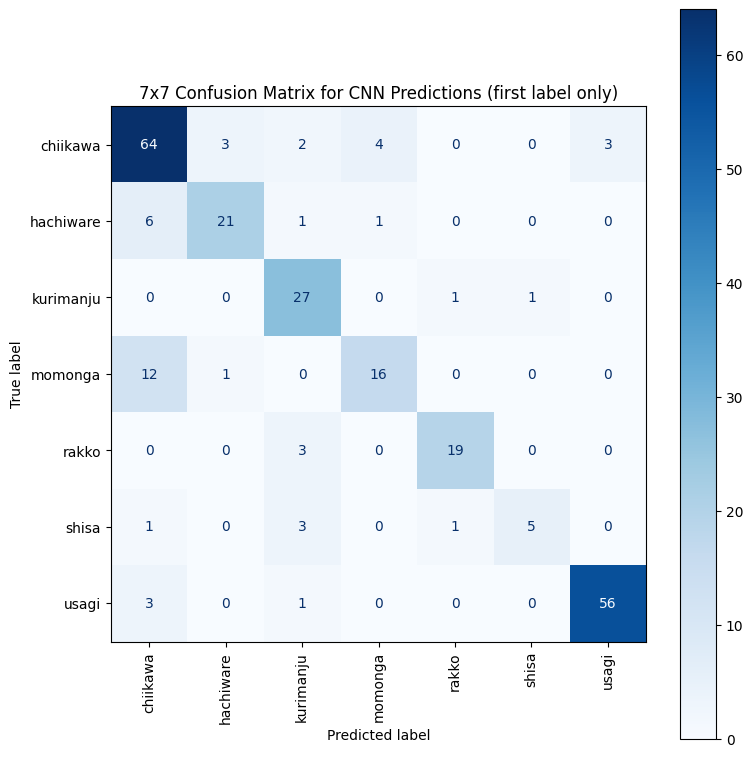

In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 類別資訊
num_classes = 7
labels = ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']

# 讀取 Ground Truth 和 預測結果 CSV
true_csv_path = '/content/image_classification_data/test_labels.csv'
pred_csv_path = '/content/test_predictions.csv'

true_df = pd.read_csv(true_csv_path)
pred_df = pd.read_csv(pred_csv_path)

# 轉換為 dict 方便查找（image_name -> class list）
true_dict = {row['image_name']: row['labels'].split() for _, row in true_df.iterrows()}
pred_dict = {
    row['image_name']: str(row['labels']).split()
    for _, row in pred_df.iterrows()
    if pd.notna(row['labels'])
}


# 收集第一個類別作為單標籤評估（若無預測或標註則略過）
y_true, y_pred = [], []

for img_name in sorted(true_dict.keys()):
    if img_name not in pred_dict:
        continue  # 沒有預測的跳過

    true_labels = true_dict[img_name]
    pred_labels = pred_dict[img_name]

    if not true_labels or not pred_labels:
        continue  # 空的跳過

    # 取第一個類別（以 int 型態儲存）
    y_true.append(int(true_labels[0]))
    y_pred.append(int(pred_labels[0]))

# === 畫 Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("7x7 Confusion Matrix for CNN Predictions (first label only)")
plt.tight_layout()
plt.show()
